In [11]:

def build_load_features(df):
    df = df.copy()

    # basic lags
    df['lag1'] = df['load_mw'].shift(1)
    df['lag24'] = df['load_mw'].shift(24)
    df['lag168'] = df['load_mw'].shift(168)

    # calendar features
    df['hour'] = df.index.hour
    df['dow'] = df.index.dayofweek
    df['doy'] = df.index.dayofyear

    # cyclical encodings
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['sin_dow'] = np.sin(2 * np.pi * df['dow'] / 7)
    df['cos_dow'] = np.cos(2 * np.pi * df['dow'] / 7)
    df['sin_doy'] = np.sin(2 * np.pi * df['doy'] / 365)
    df['cos_doy'] = np.cos(2 * np.pi * df['doy'] / 365)

    return df

import pandas as pd 
import numpy as np
from sklearn.linear_model import LinearRegression
REGION = 'PJME'
df = pd.read_csv(f"data/raw/{REGION}_hourly.csv")

# df = df.iloc[:20000]
df = df.rename(columns={'Datetime':'timestamp', f'{REGION}_MW': 'load_mw'})
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp').reset_index(drop=True)
df = df.set_index('timestamp')

df_feat = build_load_features(df)
df_feat = df_feat.dropna()
train = df_feat.loc['2008':'2010']
test  = df_feat.loc['2011']
y_train = train['load_mw']
y_test  = test['load_mw']

feature_cols = [
    'lag1', 'lag24', 'lag168',
    'sin_hour','cos_hour',
    'sin_dow','cos_dow',
    'sin_doy','cos_doy'
]


X_train = train[feature_cols].values.astype(np.float32)
X_test  = test[feature_cols].values.astype(np.float32)

mean_x = X_train.mean(axis=0)
std_x  = X_train.std(axis=0)

X_train_norm = (X_train - mean_x) / std_x
X_test_norm  = (X_test - mean_x) / std_x

# Target normalization (optional but better)
mean_y = y_train.mean()
std_y  = y_train.std()

y_train_norm = (y_train - mean_y) / std_y


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

input_dim = X_train_norm.shape[1]
model = MLP(input_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [15]:
X_t = torch.tensor(X_train_norm, dtype=torch.float32)
y_t = torch.tensor(y_train_norm.values, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_t, y_t), batch_size=128, shuffle=True)

for epoch in range(30):
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
    print(epoch, float(loss))


0 0.014319847337901592
1 0.011822419241070747
2 0.008696400560438633
3 0.007744383066892624
4 0.007602571975439787
5 0.009924717247486115
6 0.005154601763933897
7 0.004520643502473831
8 0.005245266482234001
9 0.0026438089553266764
10 0.00405638013035059
11 0.0059605748392641544
12 0.005482042208313942
13 0.003980448469519615
14 0.002748412312939763
15 0.004675676114857197
16 0.005502201616764069
17 0.00258107902482152
18 0.0032803891226649284
19 0.003286466933786869
20 0.0036486373282969
21 0.0017082411795854568
22 0.0035776812583208084
23 0.004855408798903227
24 0.0023178590927273035
25 0.0025796759873628616
26 0.0028550506103783846
27 0.0019480868941172957
28 0.003034412395209074
29 0.0022027415689080954


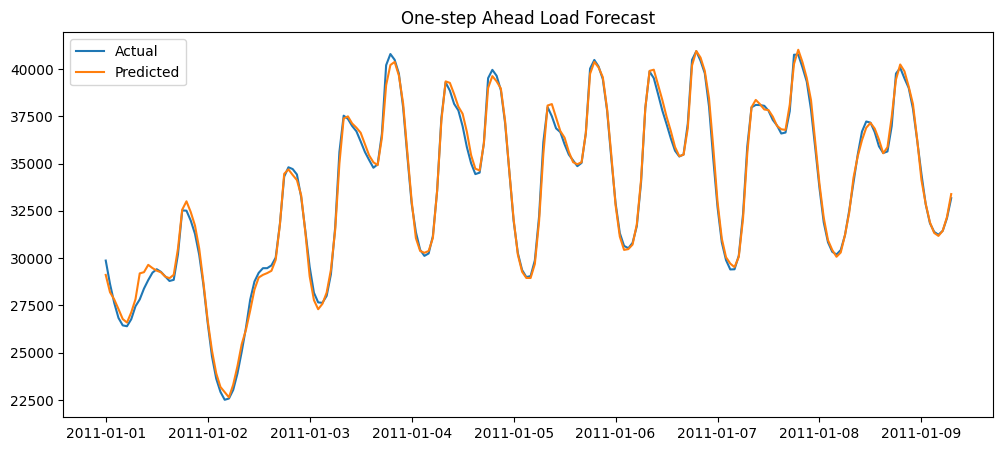

In [17]:
import matplotlib.pyplot as plt
X_test_t = torch.tensor(X_test_norm, dtype=torch.float32)

model.eval()
with torch.no_grad():
    yhat_test_norm = model(X_test_t).squeeze().numpy()

yhat_test = yhat_test_norm * std_y + mean_y

plt.figure(figsize=(12,5))
plt.plot(y_test.index[:200], y_test.values[:200], label="Actual")
plt.plot(y_test.index[:200], yhat_test[:200], label="Predicted")
plt.legend()
plt.title("One-step Ahead Load Forecast")
plt.show()


In [18]:
def multistep_forecast_load(model, df_feat, start_ts, steps=72):
    preds = []

    ts = start_ts

    for _ in range(steps):

        row = df_feat.loc[ts]

        features = row[feature_cols].values.astype(np.float32)
        features_norm = (features - mean_x) / std_x
        x = torch.tensor(features_norm, dtype=torch.float32).unsqueeze(0)

        with torch.no_grad():
            pred_norm = model(x).item()

        pred_load = pred_norm * std_y + mean_y
        preds.append(pred_load)

        # update df_feat with the new predicted load
        ts = ts + pd.Timedelta(hours=1)
        df_feat.loc[ts, 'load_mw'] = pred_load

        # update lagged features
        df_feat.loc[ts, 'lag1']   = df_feat.loc[ts - pd.Timedelta(hours=1), 'load_mw']
        df_feat.loc[ts, 'lag24']  = df_feat.loc[ts - pd.Timedelta(hours=24), 'load_mw']
        df_feat.loc[ts, 'lag168'] = df_feat.loc[ts - pd.Timedelta(hours=168), 'load_mw']

        df_feat.loc[ts, 'hour'] = ts.hour
        df_feat.loc[ts, 'dow']  = ts.dayofweek
        df_feat.loc[ts, 'doy']  = ts.dayofyear

        df_feat.loc[ts, 'sin_hour'] = np.sin(2*np.pi*ts.hour/24)
        df_feat.loc[ts, 'cos_hour'] = np.cos(2*np.pi*ts.hour/24)
        df_feat.loc[ts, 'sin_dow'] = np.sin(2*np.pi*ts.dayofweek/7)
        df_feat.loc[ts, 'cos_dow'] = np.cos(2*np.pi*ts.dayofweek/7)
        df_feat.loc[ts, 'sin_doy'] = np.sin(2*np.pi*ts.dayofyear/365)
        df_feat.loc[ts, 'cos_doy'] = np.cos(2*np.pi*ts.dayofyear/365)

    return np.array(preds)


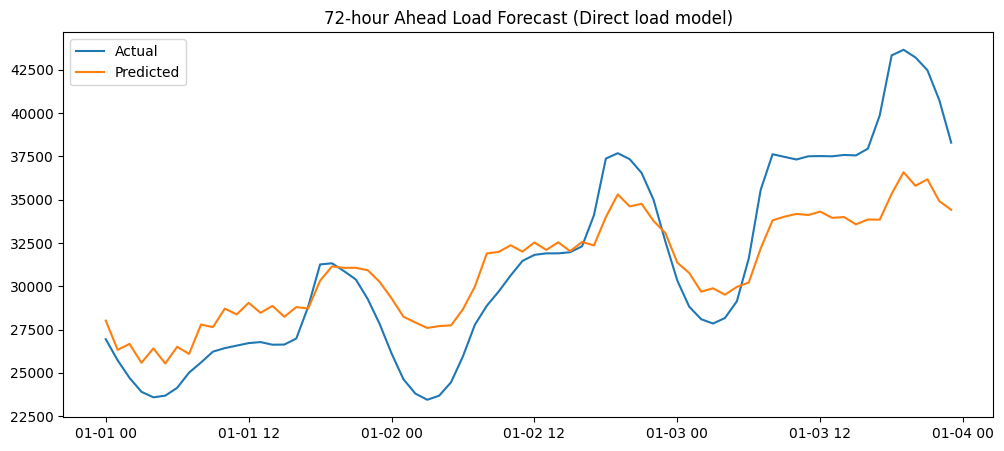

In [19]:
start_ts = test.index[-1]  # last timestamp in test set
pred_72 = multistep_forecast_load(model, df_feat.copy(), start_ts, steps=72)

actual_72 = df['load_mw'].loc[start_ts + pd.Timedelta(hours=1) :
                              start_ts + pd.Timedelta(hours=72)]

plt.figure(figsize=(12,5))
plt.plot(actual_72.index, actual_72.values, label="Actual")
plt.plot(actual_72.index, pred_72, label="Predicted")
plt.legend()
plt.title("72-hour Ahead Load Forecast (Direct load model)")
plt.show()
